<a href="https://colab.research.google.com/github/Andrea-1704/AML-labs/blob/main/Lab2_AML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Torch

In [9]:
!pip3 install 'tqdm'
!pip3 install "colorama"

import torch
#use GPU if available
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") #'cpu' # 'cuda' or 'cpu'
print(DEVICE)

cuda:0


# Download Dataset GTEA61

In [6]:
from google.colab import drive
import os
drive.mount('/content/drive')
import sys, os

#1YKfdhB9Xxh4pmND1V3gcm3Gyjc8v8idq
if not os.path.isfile('/content/drive/MyDrive'):
  #!gdown --id 1Z5RWA8yKIy0PvxMlScV-aAz22ITtivfk # 3-5 min
  !jar xvf  "/content//drive/MyDrive/GTEA61.zip"

if not os.path.isdir('/content/GTEA61'):
  print("Dataset doesn't exist")

#Weights
if not os.path.isfile("/content/best_model_state_dict_rgb_split2.pth"):
  !gdown --id 1B7Xh6hQ9Py8fmL-pjmLzlCent6dnuex5 # 3-5 min


Output streaming troncato alle ultime 5000 righe.
 inflated: GTEA61/processed_frames2/S1/spread_peanut,spoon,bread/2/mmaps/map0207.png
 inflated: GTEA61/processed_frames2/S1/spread_peanut,spoon,bread/2/mmaps/map0203.png
 inflated: GTEA61/processed_frames2/S1/spread_peanut,spoon,bread/2/mmaps/map0217.png
 inflated: GTEA61/processed_frames2/S1/spread_peanut,spoon,bread/2/mmaps/map0029.png
 inflated: GTEA61/processed_frames2/S1/spread_peanut,spoon,bread/2/mmaps/map0001.png
 inflated: GTEA61/processed_frames2/S1/spread_peanut,spoon,bread/2/mmaps/map0015.png
 inflated: GTEA61/processed_frames2/S1/spread_peanut,spoon,bread/2/mmaps/map0149.png
 inflated: GTEA61/processed_frames2/S1/spread_peanut,spoon,bread/2/mmaps/map0175.png
 inflated: GTEA61/processed_frames2/S1/spread_peanut,spoon,bread/2/mmaps/map0161.png
 inflated: GTEA61/processed_frames2/S1/spread_peanut,spoon,bread/2/mmaps/map0388.png
 inflated: GTEA61/processed_frames2/S1/spread_peanut,spoon,bread/2/mmaps/map0377.png
 inflated: GTEA


# Download Code



# Import Code


In [7]:
!git clone "https://github.com/plana93/Homework_AIML.git"
#!rm -r "/content/Homework_AIML"

Cloning into 'Homework_AIML'...
remote: Enumerating objects: 78, done.
remote: Total 78 (delta 0), reused 0 (delta 0), pack-reused 78 (from 1)
Receiving objects: 100% (78/78), 734.41 KiB | 28.25 MiB/s, done.
Resolving deltas: 100% (36/36), done.


In [10]:
import os
import logging
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.backends import cudnn
import torchvision
!p
from colorama import init
from colorama import Fore, Back, Style

from torchvision.models import resnet34
from PIL import Image
from tqdm import tqdm

import sys
sys.path.append("/content/Homework_AIML/")
import Homework_AIML
from Homework_AIML import *

from gtea_dataset import GTEA61, GTEA61_flow, GTEA61_2Stream
from spatial_transforms import (Compose, ToTensor, CenterCrop, Scale, Normalize, MultiScaleCornerCrop,
                                RandomHorizontalFlip)


/bin/bash: line 1: p: command not found


#**Learning without Temporal information** (avgpool)

#MAIN PARAMs

In [18]:
#homework_step = 0 #--> Learning without Temporal information (avgpool)
homework_step = 1 #--> Learning with Temporal information (LSTM)
#homework_step = 2 #--> Learning with Spatio-Temporal information (ConvLSTM)



DATA_DIR = '/content/GTEA61/' #path dataset
model_folder = '/content/saved_models/' + "/" + "homework_step"+ str(homework_step) + "/" #path to save model
if not os.path.isdir(model_folder):
    os.makedirs(model_folder)


# All this param can be change!

NUM_CLASSES = 61
BATCH_SIZE = 64
LR = 0.001            # The initial Learning Rate
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 4e-5  # Regularization, you can keep this at the default
NUM_EPOCHS = 50     # Total number of training epochs (iterations over dataset)
STEP_SIZE = [25, 75, 150] # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.1          # Multiplicative factor for learning rate step-down
MEM_SIZE = 512       # Dim of internal state of LSTM or ConvLSTM
SEQ_LEN = 3          # Num Frames

# this dictionary is needed for the logger class
parameters = {'DEVICE':DEVICE, 'NUM_CLASSES':NUM_CLASSES, 'BATCH_SIZE':BATCH_SIZE,
             'LR':LR, 'MOMENTUM':MOMENTUM, 'WEIGHT_DECAY':WEIGHT_DECAY, 'NUM_EPOCHS':NUM_EPOCHS,
             'STEP_SIZE':STEP_SIZE, 'GAMMA':GAMMA, 'MEM_SIZE':MEM_SIZE, 'SEQ_LEN':SEQ_LEN}

#Dataloaders & Preprocessing

In [13]:
# Normalize
normalize = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
spatial_transform = Compose([Scale(256), RandomHorizontalFlip(), MultiScaleCornerCrop([1, 0.875, 0.75, 0.65625], 224),
                             ToTensor(), normalize])
spatial_transform_val = Compose([Scale(256), CenterCrop(224), ToTensor(), normalize])


In [20]:
# Prepare Pytorch train/test Datasets
train_dataset = GTEA61(DATA_DIR, split='train', transform=spatial_transform, seq_len=SEQ_LEN)
test_dataset = GTEA61(DATA_DIR, split='test', transform=spatial_transform_val, seq_len=SEQ_LEN)

# Check dataset sizes
print('Train Dataset: {}'.format(len(train_dataset)))
print('Test Dataset: {}'.format(len(test_dataset)))

# Dataloaders iterate over pytorch datasets and transparently provide useful functions (e.g. parallelization and shuffling)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
val_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)


['S2', 'S1', 'S3', 'S4']
['S2', 'S1', 'S3', 'S4']
Train Dataset: 341
Test Dataset: 116


#Model

Ricorda che flatten lo faccio dopo le convoluzioni prima delle Fully connected.

LSTM ha dei parametri che metti nella init.

Il linear layer è una matrice + il bias e quando faccio il bias e quando faccio self.U.i(h_prev) effettua la moltiplicazione matriciale e ci aggiunge il bias.

Nota che metto bias=False perché se vedi la formula:
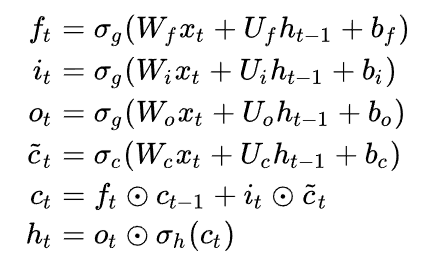
Abbiamo un solo bias. Avendo bisogno di un solo bias ne metto solo uno.

Quindi quando scrivi:
        self.W_i = nn.Linear(input_size, hidden_size)  # input gate
        self.U_i = nn.Linear(hidden_size, hidden_size, bias=False)
Qui usiao gli stessi biases.

Nota che se fai scelte strane devi metterlo nel report.

In [21]:
import torch
import resnetMod
import torch.nn as nn
from torch.nn import functional as F
from torch.autograd import Variable



# LSTM
class MyLSTMCell(nn.Module):

    def __init__(self, input_size, hidden_size):
        super(MyLSTMCell, self).__init__()
        self.input_size=input_size
        self.hidden_size=hidden_size
        super(MyLSTMCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        # Definisci layer lineari per ciascun gate
        self.W_i = nn.Linear(input_size, hidden_size)  # input gate
        self.U_i = nn.Linear(hidden_size, hidden_size, bias=False)

        self.W_f = nn.Linear(input_size, hidden_size)  # forget gate
        self.U_f = nn.Linear(hidden_size, hidden_size, bias=False)

        self.W_c = nn.Linear(input_size, hidden_size)  # cell state update
        self.U_c = nn.Linear(hidden_size, hidden_size, bias=False)

        self.W_o = nn.Linear(input_size, hidden_size)  # output gate
        self.U_o = nn.Linear(hidden_size, hidden_size, bias=False)

        # Funzioni di attivazione
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()


    def forward(self, x, state):
        if state is None:
            state = (Variable(torch.randn(x.size(0), x.size(1)).cuda()),
                     Variable(torch.randn(x.size(0), x.size(1)).cuda()))

        h_prev, c_prev = state

        # Calcolo del gate di ingresso (input gate)
        i = self.sigmoid(self.W_i(x) + self.U_i(h_prev))

        # Calcolo del gate di dimenticanza (forget gate)
        f = self.sigmoid(self.W_f(x) + self.U_f(h_prev))

        # Calcolo dell'aggiornamento dello stato della cella (cell update)
        g = self.tanh(self.W_c(x) + self.U_c(h_prev))

        # Calcolo del gate di output
        o = self.sigmoid(self.W_o(x) + self.U_o(h_prev))

        # Aggiorna lo stato della cella
        c_next = f * c_prev + i * g

        # Aggiorna lo stato nascosto
        h_next = o * self.tanh(c_next)

        # Ritorna il nuovo stato nascosto e lo stato della cella
        return h_next, c_next


#ConvLSTM
class MyConvLSTMCell(nn.Module):

    def __init__(self, input_size, hidden_size, kernel_size=3, stride=1, padding=1):
        super(MyConvLSTMCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.conv_i_xx = nn.Conv2d(input_size, hidden_size, kernel_size=kernel_size, stride=stride, padding=padding)
        self.conv_i_hh = nn.Conv2d(hidden_size, hidden_size, kernel_size=kernel_size, stride=stride, padding=padding,
                                   bias=False)

        self.conv_f_xx = nn.Conv2d(input_size, hidden_size, kernel_size=kernel_size, stride=stride, padding=padding)
        self.conv_f_hh = nn.Conv2d(hidden_size, hidden_size, kernel_size=kernel_size, stride=stride, padding=padding,
                                   bias=False)

        self.conv_c_xx = nn.Conv2d(input_size, hidden_size, kernel_size=kernel_size, stride=stride, padding=padding)
        self.conv_c_hh = nn.Conv2d(hidden_size, hidden_size, kernel_size=kernel_size, stride=stride, padding=padding,
                                   bias=False)

        self.conv_o_xx = nn.Conv2d(input_size, hidden_size, kernel_size=kernel_size, stride=stride, padding=padding)
        self.conv_o_hh = nn.Conv2d(hidden_size, hidden_size, kernel_size=kernel_size, stride=stride, padding=padding,
                                   bias=False)

        torch.nn.init.xavier_normal_(self.conv_i_xx.weight)
        torch.nn.init.constant_(self.conv_i_xx.bias, 0)
        torch.nn.init.xavier_normal_(self.conv_i_hh.weight)

        torch.nn.init.xavier_normal_(self.conv_f_xx.weight)
        torch.nn.init.constant_(self.conv_f_xx.bias, 0)
        torch.nn.init.xavier_normal_(self.conv_f_hh.weight)

        torch.nn.init.xavier_normal_(self.conv_c_xx.weight)
        torch.nn.init.constant_(self.conv_c_xx.bias, 0)
        torch.nn.init.xavier_normal_(self.conv_c_hh.weight)

        torch.nn.init.xavier_normal_(self.conv_o_xx.weight)
        torch.nn.init.constant_(self.conv_o_xx.bias, 0)
        torch.nn.init.xavier_normal_(self.conv_o_hh.weight)

    def forward(self, x, state):
        if state is None:
            state = (Variable(torch.randn(x.size(0), x.size(1)).cuda()),
                     Variable(torch.randn(x.size(0), x.size(1)).cuda()))

        # Estrai lo stato nascosto e lo stato della cella
        h_prev, c_prev = state

        # Calcolo del gate di input
        i = self.sigmoid(self.conv_i_xx(x) + self.conv_i_hh(h_prev))

        # Calcolo del gate di dimenticanza
        f = self.sigmoid(self.conv_f_xx(x) + self.conv_f_hh(h_prev))

        # Calcolo dell'aggiornamento dello stato della cella
        g = self.tanh(self.conv_c_xx(x) + self.conv_c_hh(h_prev))

        # Calcolo del gate di output
        o = self.sigmoid(self.conv_o_xx(x) + self.conv_o_hh(h_prev))

        # Aggiorna lo stato della cella
        c_next = f * c_prev + i * g

        # Aggiorna lo stato nascosto
        h_next = o * self.tanh(c_next)

        # Ritorna i nuovi stati nascosti e della cella
        return h_next, c_next




#Network
class ourModel(nn.Module):
    def __init__(self, num_classes=61, mem_size=512, homework_step = 0 , DEVICE=""):
        super(ourModel, self).__init__()
        self.DEVICE = DEVICE
        self.num_classes = num_classes
        self.resNet = resnetMod.resnet34(True, True)
        self.mem_size = mem_size
        self.weight_softmax = self.resNet.fc.weight
        self.homework_step = homework_step
        if self.homework_step == 1:
          self.lstm_cell = MyLSTMCell(512, mem_size)
        elif self.homework_step == 2:
          self.lstm_cell = MyConvLSTMCell(512, mem_size)

        self.avgpool = nn.AvgPool2d(7)
        self.dropout = nn.Dropout(0.7)
        self.fc = nn.Linear(mem_size, self.num_classes)
        self.classifier = nn.Sequential(self.dropout, self.fc)

    def forward(self, inputVariable):
        #Learning without Temporal information (mean)
        if self.homework_step == 0:
            video_level_features = torch.zeros((inputVariable.size(1), self.mem_size)).to(self.DEVICE)
            for t in range(inputVariable.size(0)):
                #spatial_frame_feat: (bs, 512, 7, 7)
                _, spatial_frame_feat, _ = self.resNet(inputVariable[t])
                #frames_feat: (bs, 512)
                frame_feat = self.avgpool(spatial_frame_feat).view(spatial_frame_feat.size(0), -1)
                video_level_features = video_level_features + frame_feat

            video_level_features = video_level_features / inputVariable.size(0)
            logits = self.classifier(video_level_features)
            return logits, video_level_features

        #Learning with Temporal information (LSTM)
        elif self.homework_step == 1:
            state = ( torch.zeros((inputVariable.size(1), self.mem_size)).to(self.DEVICE),
                     torch.zeros((inputVariable.size(1), self.mem_size)).to(self.DEVICE) )
            for t in range(inputVariable.size(0)):
                #spatial_frame_feat: (bs, 512, 7, 7)
                _, spatial_frame_feat, _ = self.resNet(inputVariable[t])
                #frames_feat: (bs, 512)
                frame_feat = self.avgpool(spatial_frame_feat).view(state[1].size(0), -1)
                state = self.lstm_cell(frame_feat, state)

            video_level_features = state[1]
            logits = self.classifier(video_level_features)
            return logits, video_level_features

        #Learning with Temporal information (ConvLSTM)
        elif self.homework_step == 2:
            state = (torch.zeros((inputVariable.size(1), self.mem_size, 7, 7)).to(self.DEVICE),
                     torch.zeros((inputVariable.size(1), self.mem_size, 7, 7)).to(self.DEVICE))
            for t in range(inputVariable.size(0)):
                #spatial_frame_feat: (bs, 512, 7, 7)
                _, spatial_frame_feat, _ = self.resNet(inputVariable[t])
                state = self.lstm_cell(spatial_frame_feat, state)
            video_level_features = self.avgpool(state[1]).view(state[1].size(0), -1)
            logits = self.classifier(video_level_features)
            return logits, video_level_features

#Build Model - Loss - Opt

In [22]:
#CUDA_LAUNCH_BLOCKING=1
validate = True

model = ourModel(num_classes=NUM_CLASSES, mem_size=MEM_SIZE, homework_step=homework_step, DEVICE=DEVICE) #model

#Train only the lstm cell and classifier
model.train(False)
for params in model.parameters():
    params.requires_grad = False

if homework_step > 0:
    for params in model.lstm_cell.parameters():
        params.requires_grad = True
    model.lstm_cell.train(True)

for params in model.classifier.parameters():
    params.requires_grad = True
model.classifier.train(True)


model = model.to(DEVICE)

#model.load_state_dict(torch.load("/content/best_model_state_dict_rgb_split2.pth", map_location=torch.device('cpu')), strict=True)


#Loss
loss_fn = nn.CrossEntropyLoss()
#Opt
trainable_params = [p for p in model.parameters() if p.requires_grad]
optimizer_fn = optim.Adam(trainable_params, lr=LR, weight_decay=WEIGHT_DECAY, eps=1e-4)
#Scheduler
optim_scheduler = optim.lr_scheduler.MultiStepLR(optimizer_fn, milestones=STEP_SIZE, gamma=GAMMA)


Qui congelo la backbone.

#Training


In [23]:
import warnings
warnings.filterwarnings('ignore')

train_iter = 0
val_iter = 0
min_accuracy = 0

trainSamples = len(train_dataset) - (len(train_dataset) % BATCH_SIZE)
val_samples = len(test_dataset)
iterPerEpoch = len(train_loader)
val_steps = len(val_loader)
cudnn.benchmark
model_checkpoint = "model" #name


for epoch in range(NUM_EPOCHS):
    epoch_loss = 0
    numCorrTrain = 0

    #blocks to train
    if homework_step > 0:
        model.lstm_cell.train(True)
    model.classifier.train(True)


    for i, (inputs, targets) in enumerate(train_loader):
        train_iter += 1
        optimizer_fn.zero_grad()

        # (BS, Frames, C, W, H) --> (Frames, BS, C, W, H)
        inputVariable = inputs.permute(1, 0, 2, 3, 4).to(DEVICE)
        labelVariable = targets.to(DEVICE)

        # feeds in model
        output_label, _ = model(inputVariable)

        # compute loss
        loss = loss_fn(output_label, labelVariable)

        # backward loss and optimizer step
        loss.backward()
        optimizer_fn.step()

        #compute the training accuracy
        _, predicted = torch.max(output_label.data, 1)
        numCorrTrain += torch.sum(predicted == labelVariable.data).data.item()
        step_loss = loss.data.item()
        epoch_loss += step_loss

    avg_loss = epoch_loss/iterPerEpoch
    trainAccuracy = (numCorrTrain / trainSamples) * 100
    #train_logger.add_epoch_data(epoch+1, trainAccuracy, avg_loss)
    print(Fore.BLACK + 'Train: Epoch = {} | Loss = {:.3f} | Accuracy = {:.3f}'.format(epoch+1, avg_loss, trainAccuracy))
    if validate:
        if (epoch+1) % 1 == 0:
            model.train(False)
            val_loss_epoch = 0
            numCorr = 0
            for j, (inputs, targets) in enumerate(val_loader):
                val_iter += 1
                inputVariable = inputs.permute(1, 0, 2, 3, 4).to(DEVICE)
                labelVariable = targets.to(DEVICE)

                output_label, _ = model(inputVariable)
                val_loss = loss_fn(output_label, labelVariable)
                val_loss_step = val_loss.data.item()
                val_loss_epoch += val_loss_step
                _, predicted = torch.max(output_label.data, 1)
                numCorr += torch.sum(predicted == labelVariable.data).data.item()
                #val_logger.add_step_data(val_iter, numCorr, val_loss_step)

            val_accuracy = (numCorr / val_samples) * 100
            avg_val_loss = val_loss_epoch / val_steps

            print(Fore.GREEN + 'Val: Epoch = {} | Loss {:.3f} | Accuracy = {:.3f}'.format(epoch + 1, avg_val_loss, val_accuracy))
            if val_accuracy > min_accuracy:
                print("[||| NEW BEST on val||||]")
                save_path_model = os.path.join(model_folder, model_checkpoint)
                torch.save(model.state_dict(), save_path_model)
                min_accuracy = val_accuracy

    optim_scheduler.step()

print(Fore.CYAN + "Best Acc --> ", min_accuracy)
print(Fore.CYAN + "Last Acc --> ", val_accuracy)


Train: Epoch = 1 | Loss = 4.288 | Accuracy = 0.938
Val: Epoch = 1 | Loss 3.908 | Accuracy = 6.034
[||| NEW BEST on val||||]
Train: Epoch = 2 | Loss = 4.111 | Accuracy = 7.500
Val: Epoch = 2 | Loss 3.855 | Accuracy = 8.621
[||| NEW BEST on val||||]
Train: Epoch = 3 | Loss = 3.997 | Accuracy = 4.375
Val: Epoch = 3 | Loss 3.807 | Accuracy = 12.069
[||| NEW BEST on val||||]
Train: Epoch = 4 | Loss = 3.970 | Accuracy = 5.625
Val: Epoch = 4 | Loss 3.775 | Accuracy = 7.759
Train: Epoch = 5 | Loss = 3.869 | Accuracy = 7.812
Val: Epoch = 5 | Loss 3.728 | Accuracy = 11.207
Train: Epoch = 6 | Loss = 3.851 | Accuracy = 11.250
Val: Epoch = 6 | Loss 3.667 | Accuracy = 12.931
[||| NEW BEST on val||||]
Train: Epoch = 7 | Loss = 3.721 | Accuracy = 12.188
Val: Epoch = 7 | Loss 3.596 | Accuracy = 12.069
Train: Epoch = 8 | Loss = 3.694 | Accuracy = 12.188
Val: Epoch = 8 | Loss 3.520 | Accuracy = 16.379
[||| NEW BEST on val||||]
Train: Epoch = 9 | Loss = 3.670 | Accuracy = 12.812
Val: Epoch = 9 | Loss 3.46

#Test

In [24]:
model.train(False)
val_loss_epoch = 0
numCorr = 0
val_iter = 0
val_samples = len(test_dataset)
val_steps = len(val_loader)

with torch.no_grad():
    for j, (inputs, targets) in enumerate(val_loader):
        val_iter += 1
        inputVariable = inputs.permute(1, 0, 2, 3, 4).to(DEVICE)
        labelVariable = targets.to(DEVICE)

        output_label, _ = model(inputVariable)
        val_loss = loss_fn(output_label, labelVariable)
        val_loss_step = val_loss.data.item()
        val_loss_epoch += val_loss_step
        _, predicted = torch.max(output_label.data, 1)
        numCorr += torch.sum(predicted == labelVariable.data).data.item()

    val_accuracy = (numCorr / val_samples) * 100
    avg_val_loss = val_loss_epoch / val_steps

print('Loss {:.3f} | Accuracy = {:.3f}'.format(avg_val_loss, val_accuracy))

Loss 2.453 | Accuracy = 33.621


#**Learning with Temporal information** (LSTM)

#**Learning with Spatio-Temporal information** (ConvLSTM)



